# Load cleaned data 

In [1]:
import pandas as pd
df = pd.read_csv('data/sample_5000_clean.csv', index_col="Unnamed: 0")
print(df.shape)
df.head()

(5000, 6)


,Index,date,text,title,week,clean_text
5038,621031,2017-10-26 15:00:54,eBay launches visual search tools that let you...,eBay launches visual search tools that let you...,2017-10-29 00:00:00,ebay launches visual search tools let shop usi...
5039,621032,2017-10-26 00:00:00,Monsanto Attacks Scientists After Studies Show...,Monsanto Attacks Scientists After Studies Show...,2017-10-29 00:00:00,attacks scientists after studies show trouble ...
5040,621035,2017-10-26 14:41:12,"Hard Drive Stats for Q3 2017In Q3 2017, Backbl...",2017 Hard Drive Reliability by Drive Size and ...,2017-10-29 00:00:00,hard drive stats introduced both tb tb hard dr...
5041,621036,2017-10-26 15:27:11,This is part 1 of the “How Unreal Renders a Fr...,How Unreal Renders a Frame,2017-10-29 00:00:00,part how renders frame series access part part...
5042,621423,2017-10-26 16:02:00,Boeing builds towards its first space taxi tes...,Boeing builds towards its first space taxi test,2017-10-29 00:00:00,builds towards first space taxi nasa first nam...


# Latent Dirichlet Allocation

We use [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html).

Make sure to also check out [gensim](https://radimrehurek.com/gensim/) and [spacy](https://spacy.io/) and the [transformers library](https://github.com/huggingface/transformers).

In [2]:
from IPython.display import IFrame    
display(IFrame("https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html", width=1300, height=500))

In [23]:
# Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Lars Buitinck
#         Chyi-Kwei Yau <chyikwei.yau@gmail.com>
# License: BSD 3 clause
# https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

from time import time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


n_samples = 3000
min_df=0.005
max_df=0.6
n_components = 15
n_top_words = 20


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


t0 = time()
data = df.clean_text.values
data_samples = data[:n_samples]

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=max_df, min_df=min_df, stop_words='english')
%time tf = tf_vectorizer.fit_transform(data_samples)

lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,learning_method='online',random_state=0)
%time lda.fit(tf)

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Extracting tf features for LDA...
Wall time: 790 ms
Wall time: 13.4 s

Topics in LDA model:
Topic #0: uber car cars tesla selfdriving electric company vehicle vehicles driving drivers ubers ev miles city mile autonomous waymo model said
Topic #1: sec drives ces drive vpn techradar january storage vegas hard las tb class tier unlimited proxy offering years enterprise data
Topic #2: people time work think way dont make know really thats good things years say said going did im want world
Topic #3: data use app users using need apps security make software access code service want time user youre dont information available
Topic #4: youre music best smart home watch tv vr device good thats theres features sound youll want great devices screen headphones
Topic #5: data used researchers learning study university research state example machine number use time different function using science training test scientists
Topic #6: apple iphone phone oneplus samsung phones galaxy apples face camera 

# Wordclouds

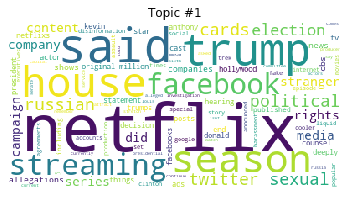

In [5]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

def get_top_words(model, feature_names, n_top_words, topics):
    """ Get top words per topic from lda model """
    for topic_idx, topic in enumerate(model.components_):
        if not int(topics) == topic_idx:
            continue
        
        words = [feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]]
        
        probs = [topic[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        return dict(zip(words, probs))
    
def sklearn_lda_wordcloud(model, feature_names, n_top_words, topic):
    """ Create wordcloud from lda model """
    wc = WordCloud(background_color="white").fit_words(get_top_words(model, feature_names, n_top_words, topic))
    plt.imshow(wc)
    plt.axis("off")
    plt.title("Topic #" + str(topic))
    return wc

sklearn_lda_wordcloud(lda, tf_feature_names, 100, 1)

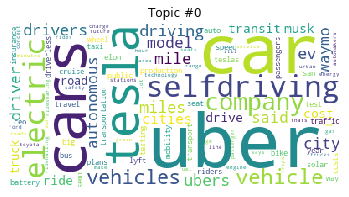

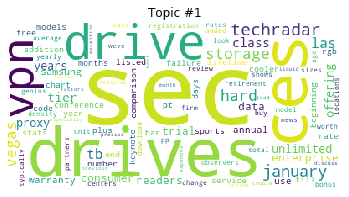

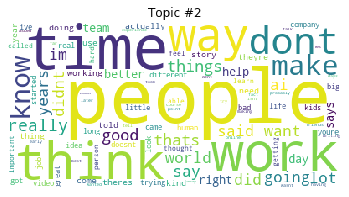

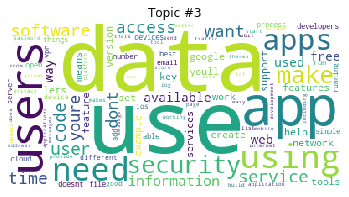

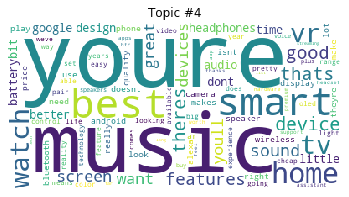

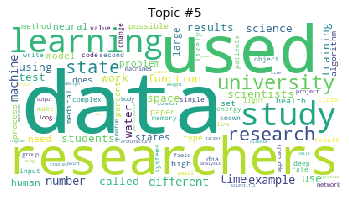

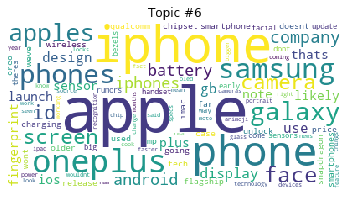

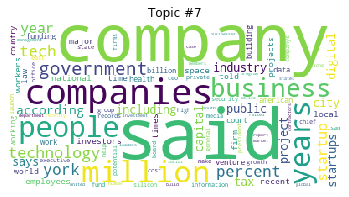

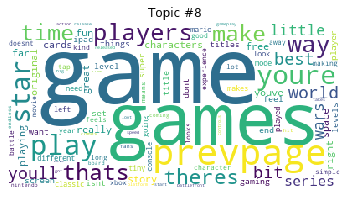

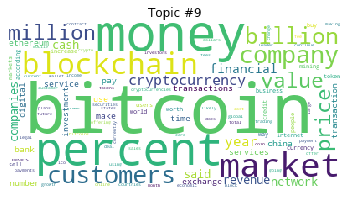

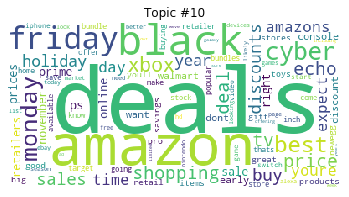

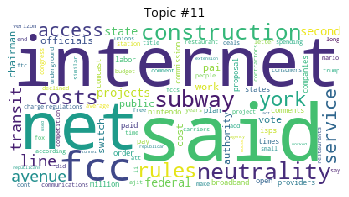

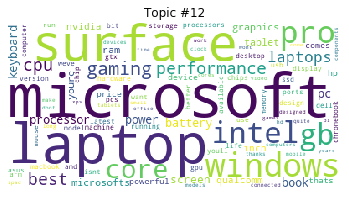

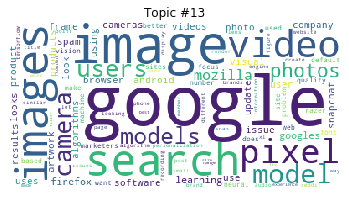

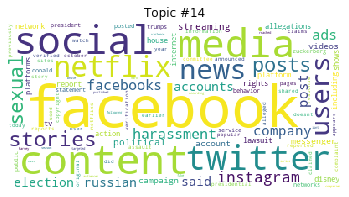

In [32]:
for i in range(15):
    wc = sklearn_lda_wordcloud(lda, tf_feature_names, 100, i)
    plt.imshow(wc)
    plt.show()
    

# Model evaluation
- We use Perplexity for simplicity, however it is better to use topic coherence.
- Still one should not bother too much about but evaluation metrics like perplexity or topic coherence but rather inform the choice of model by the area of application. Learning more about this isa direction of current research.


In [8]:
lda.perplexity(tf)

3467.9835127301503

In [9]:
# train second model with same hyperparameters but different random seed
lda2 = LatentDirichletAllocation(n_components=n_components, max_iter=5, learning_method='online', random_state=1)
lda2.fit(tf)
print(lda.perplexity(tf_vectorizer.transform(data[n_samples:])))
lda2.perplexity(tf_vectorizer.transform(data[n_samples:]))


3527.8817718339556


3494.371927588134

# Hyperparameter Tuning

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

In [10]:
display(IFrame("https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html", width=1300, height=200))

In [19]:
import numpy as np
np.random.seed(42)
from sklearn.externals import joblib

from sklearn.model_selection import RandomizedSearchCV
import scipy.stats
import os

randomState = 444
n_runs = 5 # number of tries for Random Search
min_df = 0.005 # tf min df; old version: min_df = 5
max_df = 0.60 # tf max df
lda_max_iter = 5
min_topics, max_topics = 10, 20
verbose = 1 # how much feedback during optimization. 0 = no feedback, 1 = a bit more, 2 = even more

# Random Search parameter grid
param_dist = {'n_components': list(range(min_topics, max_topics )),
              'learning_decay': scipy.stats.uniform(0, 1),
              'doc_topic_prior': scipy.stats.uniform(0, 1), # alpha
              'topic_word_prior': scipy.stats.uniform(0, 1), # beta
              }

# define models
lda_random = LatentDirichletAllocation(max_iter=lda_max_iter, random_state=randomState)
model_random = RandomizedSearchCV(lda_random,
                                  param_distributions=param_dist,
                                  random_state=randomState,
                                  n_iter=n_runs,
                                  verbose=verbose ,
                                  cv=3
                                  )

# Do the random Search
%time model_random.fit(tf)

Random Search
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   27.8s finished


Wall time: 30.6 s


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=LatentDirichletAllocation(batch_size=128,
                                                       doc_topic_prior=None,
                                                       evaluate_every=-1,
                                                       learning_decay=0.7,
                                                       learning_method='batch',
                                                       learning_offset=10.0,
                                                       max_doc_update_iter=100,
                                                       max_iter=5,
                                                       mean_change_tol=0.001,
                                                       n_components=10,
                                                       n_jobs=None,
                                                       perp_tol=0.1,
                                                       random_state=44

In [20]:
# Best Model
best_lda_model_random = model_random.best_estimator_
# Model Parameters
print("Best Model's Params: ", model_random.best_params_)
# Log Likelihood Score
print("Best Log Likelihood Score: ", model_random.best_score_)

random_search_results = pd.DataFrame(model_random.cv_results_).sort_values('rank_test_score')
random_search_results.head()

Best Model's Params:  {'doc_topic_prior': 0.686283549981997, 'learning_decay': 0.7148637722981328, 'n_components': 10, 'topic_word_prior': 0.7397423008958642}
Best Log Likelihood Score:  -478138.9076282392


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_doc_topic_prior,param_learning_decay,param_n_components,param_topic_word_prior,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
3,1.794863,0.063727,0.157911,0.008783,0.686284,0.714864,10,0.739742,"{'doc_topic_prior': 0.686283549981997, 'learni...",-415683.669236,-558087.768405,-460645.285243,-478138.907628,59437.653515,1
2,1.754970,0.090738,0.176528,0.010772,0.316361,0.193592,12,0.834896,"{'doc_topic_prior': 0.31636050352204015, 'lear...",-417204.686844,-559665.883318,-463124.043780,-479998.204647,59370.874475,2
4,1.758960,0.063712,0.158908,0.010182,0.493409,0.473012,10,0.496006,"{'doc_topic_prior': 0.49340914215266685, 'lear...",-418163.503494,-562046.318347,-463743.574709,-481317.798850,60040.020642,3
0,1.699120,0.022979,0.137632,0.010679,0.839361,0.821295,13,0.56419,"{'doc_topic_prior': 0.839361047440404, 'learni...",-422673.935344,-565248.040483,-468133.500464,-485351.825430,59465.378723,4
1,1.552180,0.052631,0.107047,0.009438,0.901208,0.203187,19,0.276501,"{'doc_topic_prior': 0.9012077155645184, 'learn...",-436101.816400,-580612.080951,-483637.096635,-500116.997996,60135.926598,5


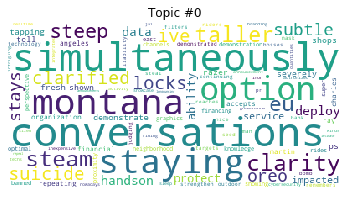

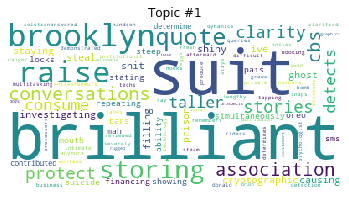

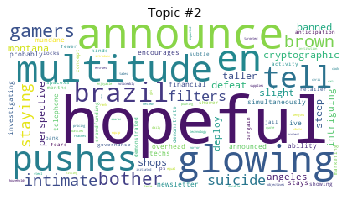

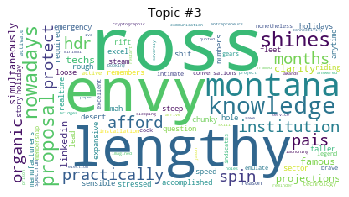

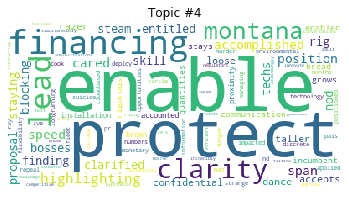

In [24]:
for i in range(5):
    wc = sklearn_lda_wordcloud(best_lda_model_random, tf_feature_names, 100, i)
    plt.imshow(wc)
    plt.show()
    

# Save Models for later

In [31]:
# make dirs
os.makedirs("results/", exist_ok=True)
os.makedirs("models/", exist_ok=True)

# save objects
joblib.dump(lda, 'models/lda')  
random_search_results.to_csv('results/random_search_results.csv', sep="\t")
joblib.dump(tf_vectorizer, 'models/tfvec')
joblib.dump(tf, 'models/tf')

['models/tf']

In [30]:
tf_vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.6, max_features=None, min_df=0.005,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)